### **Projeto Final Chatbot - Disciplina Programação Estruturada QS 2020**
Profº Gazziro

Grupo 31:

**Filipe Gomes           RA 21061712**

**Luis Gustavo Paiva     RA 11201722853**

**Matheus Augusto Pinto  RA 11201721392**

**Número de casas classificadas corretamente pelo Chatbot: 8 de 10**

*Zipcode* : 98027

* **Importando as Bibliotecas Necessárias**

In [1]:
from sklearn import tree, metrics, model_selection, preprocessing
from IPython.display import Image, display
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.tree import _tree
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import sys
import os
import io

* **Lendo o arquivo completo com as informações sobre as casas** 

In [2]:
zipcode = 98027
path = r"C:\Users\mathe\Documents\QS_2020_UFABC\ProgramacaoEstruturada\Code\kc_house_data.csv"
arquivo = pd.read_csv(path, sep=",",encoding='utf-8')
arquivo[['zipcode']] = arquivo[['zipcode']].astype(int)

* **Filtrando o Dataframe com relação ao nosso ZIPCODE**

In [3]:
arq_grupo = arquivo.copy()
#arq_grupo = arq_grupo.sample(frac=1).reset_index(drop=True)
arq_grupo = arq_grupo[arq_grupo['zipcode']==zipcode].reset_index(drop=True)
arq_grupo.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,8562750320,20141110T000000,580500.0,3,2.50,2320,3980,2.0,0,0,...,8,2320,0,2003,0,98027,47.5391,-122.070,2580,3980
1,9545230140,20140725T000000,597750.0,4,2.50,2310,9624,2.0,0,0,...,8,2310,0,1984,0,98027,47.5386,-122.053,1940,9636
2,9545240070,20150428T000000,660500.0,4,2.25,2010,9603,1.0,0,0,...,8,1440,570,1986,0,98027,47.5343,-122.054,2060,9793
3,3224079105,20140806T000000,430000.0,2,2.50,2420,60984,2.0,0,0,...,7,2420,0,2007,0,98027,47.5262,-121.943,1940,193842
4,2617300160,20140812T000000,420000.0,3,2.00,2020,38332,1.0,0,0,...,7,1010,1010,1975,0,98027,47.4582,-122.023,2110,36590


* **Visualização das distribuições dos dados no nosso conjunto de dados filtrados**

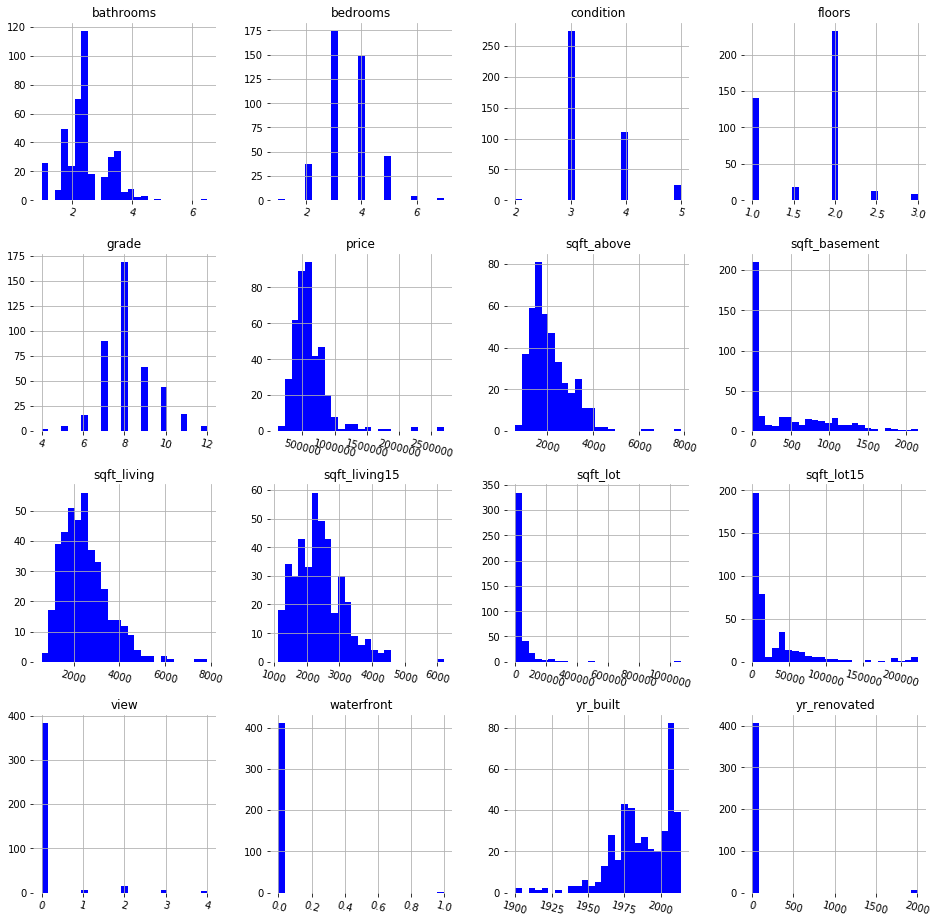

In [4]:
data_visualization =arq_grupo[['price', 'bedrooms', 'bathrooms', 'sqft_living',
        'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
        'sqft_living15', 'sqft_lot15']]

h = data_visualization.hist(bins=25,figsize=(16,16),xlabelsize='10',ylabelsize='10',xrot=-15,color='b')
sns.despine(left=True, bottom=True)
[x.title.set_size(12) for x in h.ravel()];
[x.yaxis.tick_left() for x in h.ravel()];

* **Dimensões do Dataframe de Estudo**

In [5]:
arq_tree = arq_grupo.copy()
data_visualization
arq_tree = arq_tree.dropna()
print('O dataframe a ser estudado possui as seguintes dimensões: ', arq_tree.shape)

O dataframe a ser estudado possui as seguintes dimensões:  (412, 21)


* **Calculando o Z-Score dada a relação de price/sqft_living**

In [6]:
arq_tree.loc[:,'price_sq_meter'] = arq_tree.loc[:,'price']/arq_tree.loc[:,'sqft_living']
arq_tree.loc[:,'zscore'] =  (arq_tree.loc[:,'price_sq_meter'] - arq_tree['price_sq_meter'].mean())/arq_tree['price_sq_meter'].std(ddof=0)

# Dataframe para teste do modelo criado (últimas 10 linhas)
arq_teste = arq_tree.iloc[pd.np.r_[-10:0]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """


* **Geração da Matriz de Correlação de Pearson para nortear a escolha das colunas a serem utilizadas**

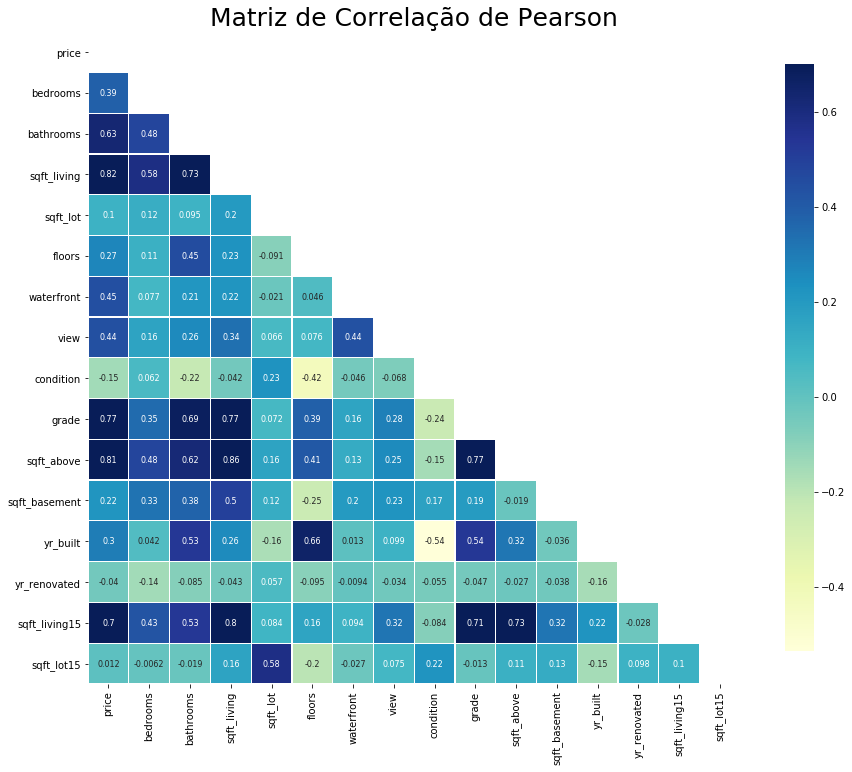

In [7]:
arq_tree =  arq_tree.loc[~arq_tree.index.isin(arq_teste.index)]
features = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront',
            'view','condition','grade','sqft_above','sqft_basement','yr_built','yr_renovated',
            'sqft_living15','sqft_lot15']

mask = np.zeros_like(arq_tree[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Matriz de Correlação de Pearson',fontsize=25)

sns.heatmap(arq_tree[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="YlGnBu",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

* **Definição das casas entre Médias, Caras e Baratas a partir do Z-score**

In [8]:
def normalized_score(line):
    
    """0: casa na média
       1: casa barata
       2: casa cara"""
    
    i = 0.7
    
    if abs(line.zscore)<=i:
        return 0
    elif line.zscore>i:
        return 2
    else:
        return 1

# Classificação das casas tanto do df global como o df de teste

arq_tree['zscore_norm']  = arq_tree.apply(normalized_score,axis=1)
arq_teste['zscore_norm']  = arq_teste.apply(normalized_score,axis=1)

* **Discretização dos dados das colunas utilizadas no modelo**

In [9]:
#Lista de colunas com exceção da localização a serem utilizadas
lista_colunas = ['bedrooms','sqft_above','grade','bathrooms','waterfront','view','sqft_living','sqft_living15','floors']

#Armazenar as colunas com nomes diferentes e normalizadas
colunas_novas = []

#Armazenas as médias para utilizar nas perguntas do Chatbot
lista_medias = {}

def discretizacao_kmeans(coluna):
    
    """Função para discretizar utilizando o kmeans"""
    
    pricesT=[]
    prices= arq_tree[coluna].values
    
    for price in prices:
        pricesT.append([price])
        
    kmeans_price = KMeans(n_clusters= 2, random_state=0).fit(pricesT)
    
    media = kmeans_price.cluster_centers_
    media = (media[0][0]+media[1][0])/2
    
    prices_disc=[]
    
    for price in prices:
        price_disc = kmeans_price.predict([[price]])
        prices_disc.append(price_disc[0])
    
    colunas_novas.append(coluna+'_discretized')
    arq_tree[coluna+'_discretized']= prices_disc
    
    # Adicionar a lista de médias de acordo com a coluna
    lista_medias.update({coluna+'_discretized': round(media,2)})

#Aplicando a função kmeans_func para cada coluna

for col in lista_colunas:
    discretizacao_kmeans(col)

#Discretização da Latitude e Longitude

locations= arq_tree[['lat','long']].values
kmeans_loc = KMeans(n_clusters = 2, random_state=0).fit(locations)

locations_disc=[]

for location in locations:
    location_disc = kmeans_loc.predict([location])
    locations_disc.append(location_disc[0])

location_teste = []
locations= arq_teste[['lat','long']].values

for location in locations:
    location_disc = kmeans_loc.predict([location])
    location_teste.append(location_disc[0])

arq_teste['locations_discretized'] = location_teste

arq_teste = arq_teste[lista_colunas+['locations_discretized','zscore_norm']]

#Salvando o arquivo de teste em .csv para visualização de como está funcionando
arq_teste.to_csv(r'C:\Users\mathe\Documents\QS_2020_UFABC\ProgramacaoEstruturada\Code\arquivo_teste.csv')

arq_tree['locations_discretized']=locations_disc
colunas_novas+=['locations_discretized']
lista_medias.update({'locations_discretized': 0.5})

arq_tree.to_csv(r'C:\Users\mathe\Documents\QS_2020_UFABC\ProgramacaoEstruturada\Code\arquivo_tratado.csv')

* **Utilizando o Sklearn DecisionTreeClassifier para gerar a árvore de decisão**

Os parâmetros utilizados são o:

*test_size* : tamanho da amostra de teste em relação ao total do dataframe

*max_depth* : máxima profundidade da árvore de decisão

*min_impurity_decrease* : diminuição mínima da impureza para gerar um novo galho

*min_samples_split* : número mínimo de amostras para dividir um nó

In [10]:
y = arq_tree['zscore_norm'].copy()  #objetivo ou coluna target
x = arq_tree[colunas_novas]  #colunas que iremos buscar relacoes

# Dividindo os dados aleatoriamente em teste e treino

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.025, random_state=0)

# Treinando a árvore de decisão
dtree = tree.DecisionTreeClassifier(max_depth= 8,random_state = 1,min_impurity_decrease= 0.0015, min_samples_split = 8)
clf = dtree.fit(X_train, y_train)

* **Teste do modelo checando a acurácia com a própria biblioteca e os 10% de teste**

In [11]:
y_pred = dtree.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.73


* **Geração da Árvore de Decisão em Formato de Texto**

In [12]:
text_representation = tree.export_text(dtree, feature_names = colunas_novas, show_weights = True)
s = io.StringIO(text_representation)

with open('fileName.csv', 'w') as f:
    for line in s:
        f.write(line)        

* **Plotagem da árvore de decisão**

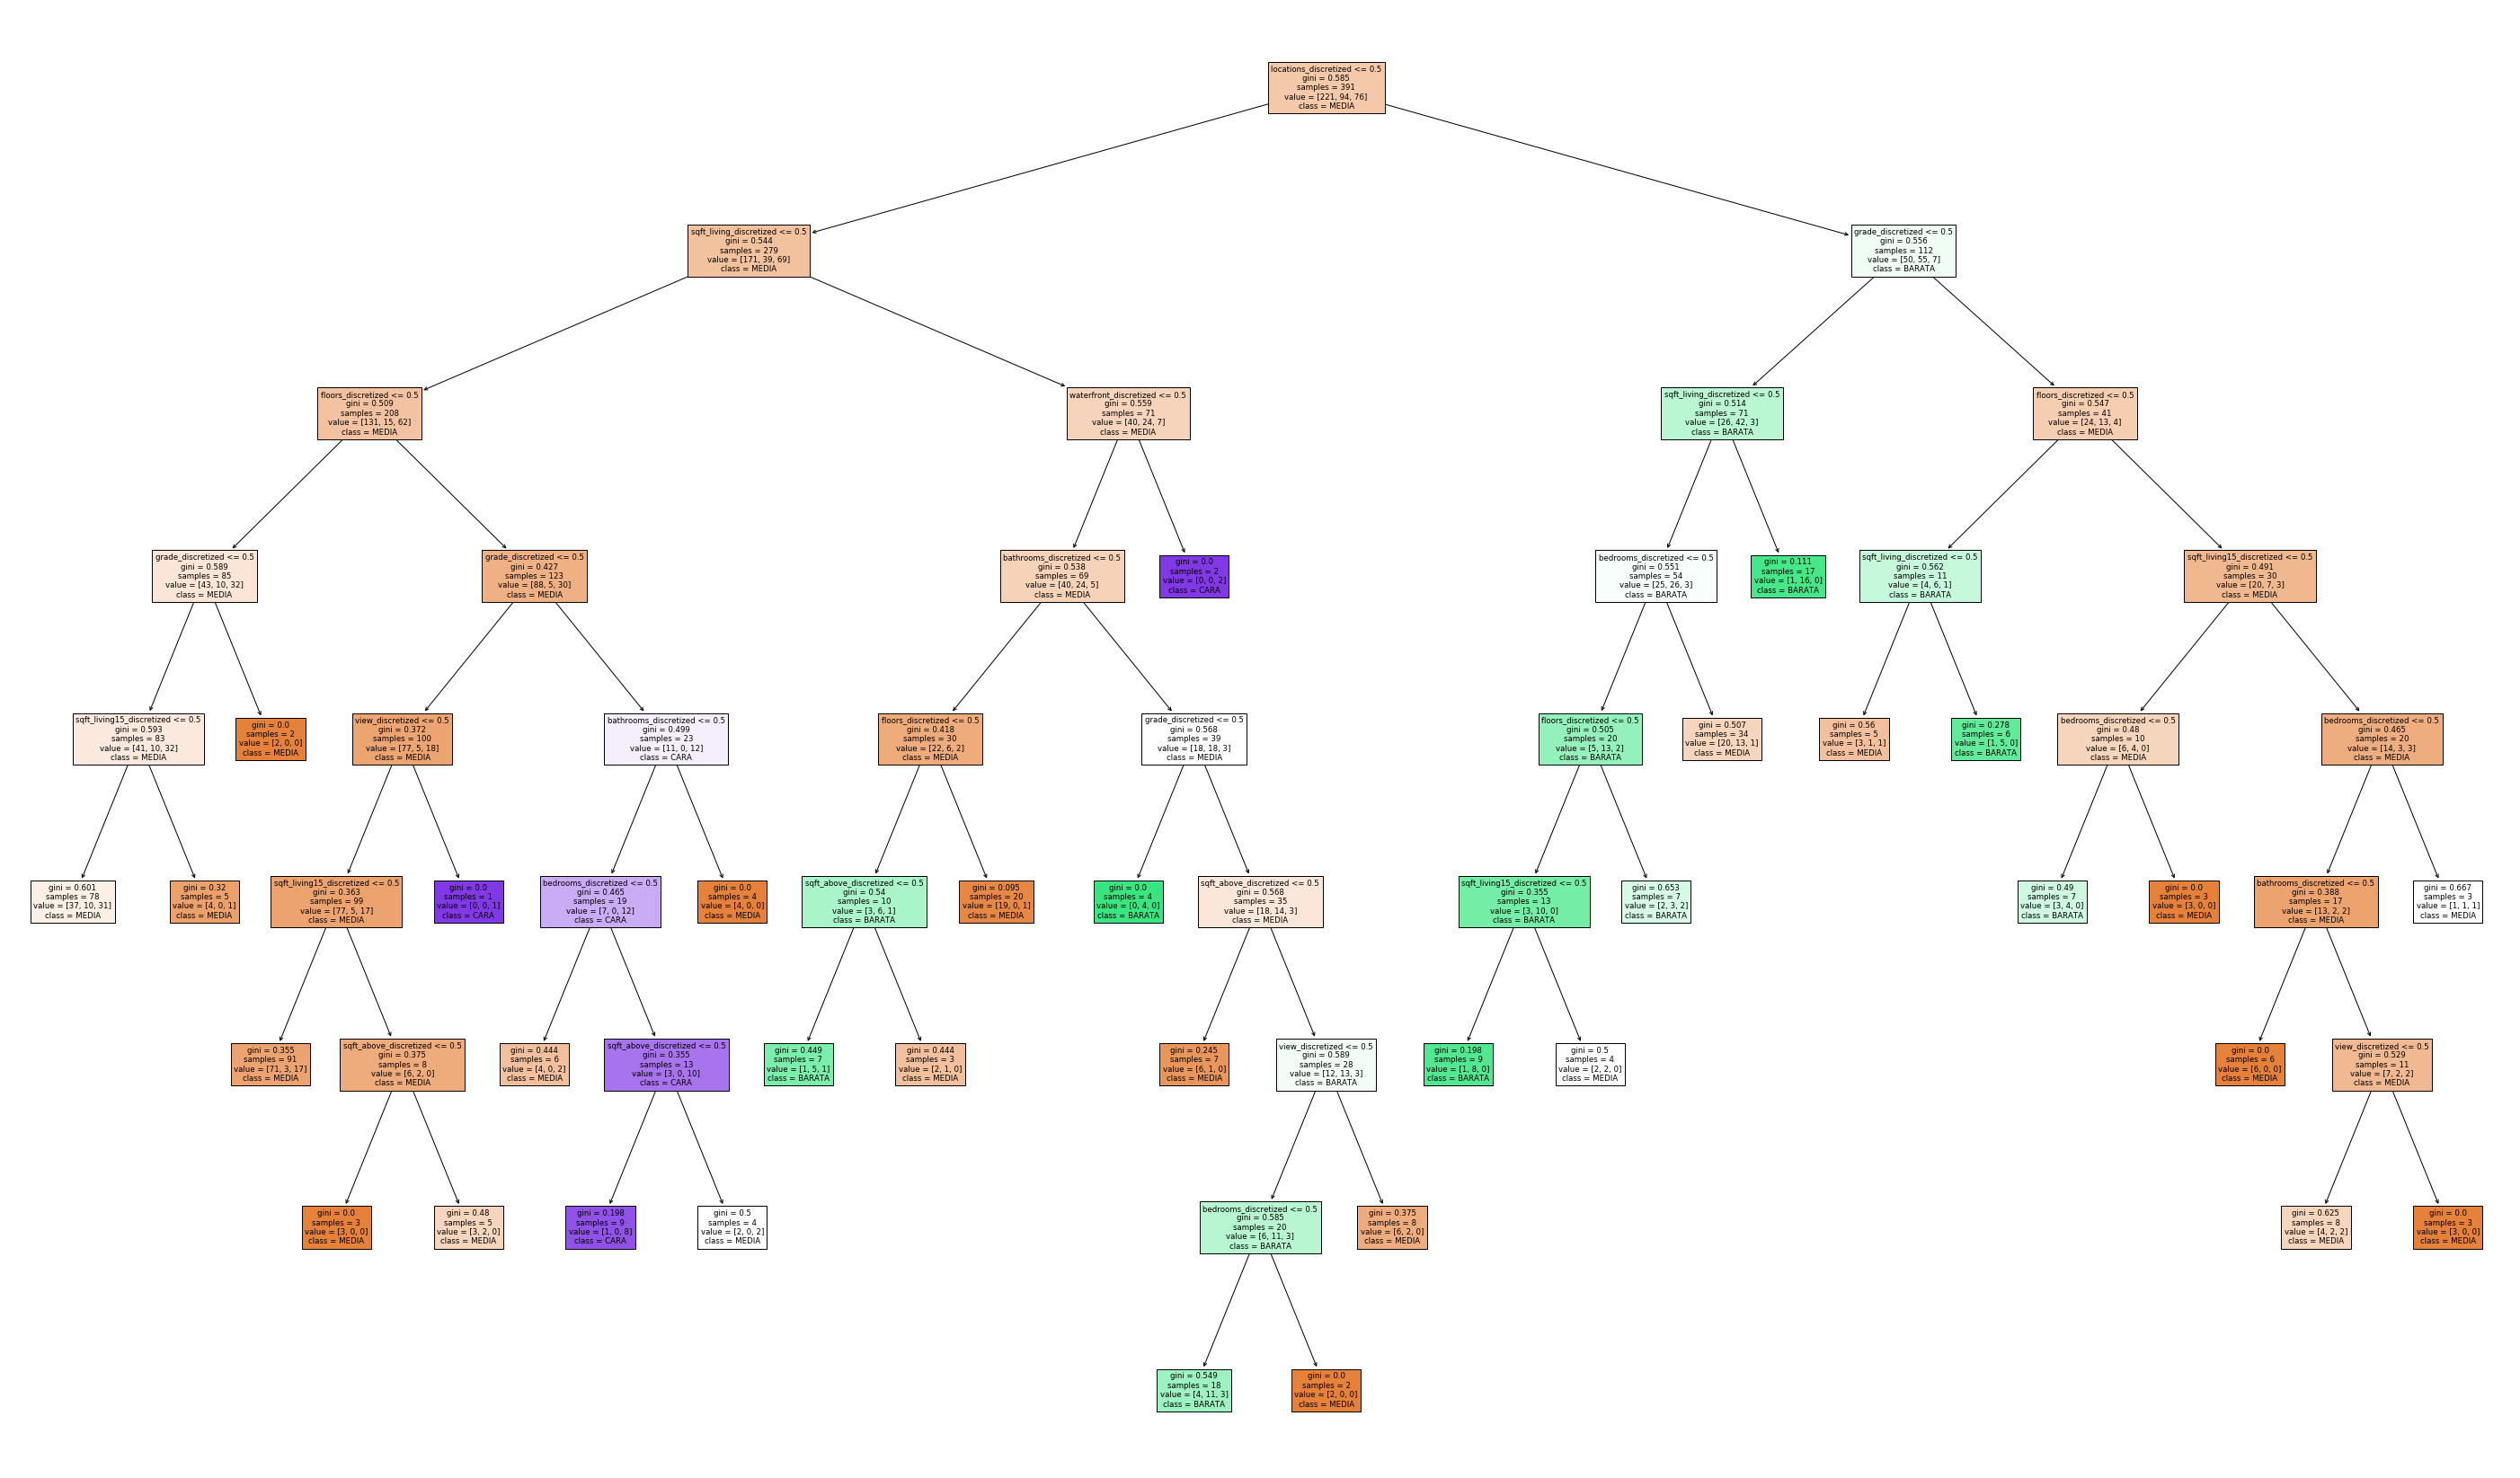

In [13]:
fig = plt.figure(figsize=(50,30))
_ = tree.plot_tree(dtree, 
                   feature_names=colunas_novas,  
                   class_names = ['MEDIA','BARATA','CARA'],
                   filled=True)

* **Geração do arquivo .dot para possibilitar salvar a árvore em .png**

In [14]:
#Escreve arquivo .dot para gerar a 
export_graphviz(clf, out_file='tree.dot', 
                feature_names = colunas_novas,
                class_names = ['MEDIA','BARATA','CARA'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

* **Gerando a engine do chatbot**

*clr.tree_.feature returns the nodes/leaves in a sequential order as a Depth-First Search algorithm.*

In [15]:
#https://gist.github.com/eherrerosj/ed3400b06f3c5c7668c62653e2a695c2
#Local que encontramos o código no GitHub

#Tradução das perguntas para melhor UX

perguntas = {'bedrooms_discretized': r'number of bedrooms',
             'sqft_above_discretized': 'number of sqft above',
             'grade_discretized': "grade",
             'bathrooms_discretized':'number of bathrooms',
             'waterfront_discretized': 'waterfront classification',
             'view_discretized': 'view classified as',
             'sqft_living_discretized': 'number of sqft living',
             'sqft_living15_discretized': 'number sqft living 15',
              'locations_discretized':'location discretized',
            'floors_discretized':'number of floors'}

texto = ['\n']

def tree_to_code(tree, feature_names):
    
    """Função que recebe a árvore de decisão e 
    suas colunas gerando o mecanismo de if/else. Assim,
    sendo utilizada como engine do chatbot."""
    
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        global texto
        indent = "    " * (depth+1)
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            texto.append(rf"{indent}{name.replace('_','')} = float(validaEntrada('Is the {perguntas[name]} <= {lista_medias[name]}?'))")
            texto.append(rf"{indent}if {name.replace('_','')} <= {threshold}:")
            recurse(tree_.children_left[node], depth + 1)
            texto.append(rf"{indent}else:  # if {name.replace('_','')} > {threshold}")
            recurse(tree_.children_right[node], depth + 1)
        else:
            texto.append("{}return({})".format(indent, np.argmax(tree_.value[node])))

    recurse(0, 1)

tree_to_code(dtree,colunas_novas)

# Abrindo o código .py (template) para, a partir da estrutura de if/else gerada, conseguir criar a engine do chatbot
# realizando um append linha a linha e retornado um novo código python que será chamado posteriormente

with open('templateEngine.py','r', encoding="utf-8") as reader, open('engine.py', 'w',encoding="utf-8") as writer:
    arquivo = reader.readlines()
    writer.writelines(arquivo)
    for line in texto:
        writer.write(line)
        writer.write("\n")
    
writer.close()

def tree(bedrooms_discretized, sqft_above_discretized, grade_discretized, bathrooms_discretized, waterfront_discretized, view_discretized, sqft_living_discretized, sqft_living15_discretized, floors_discretized, locations_discretized):


* **Importando o código gerado e sua função chatbotEngine e inicializando o chatbot**

In [ ]:
sys.path.append(r'C:\Users\mathe\Documents\QS_2020_UFABC\ProgramacaoEstruturada\Code')
from engine import chatbotEngine

while True:
    resposta = chatbotEngine()
    
    if resposta == 0:
        print('Esta casa deve estar na média!\n')
    elif resposta ==1:
        print('Esta casa é barata!\n')
    else:
        print('Esta casa é cara!\n')
    
    entrada = int(input('Digite 1 para Continuar e qualquer outro valor numérico para sair...\n'))
    
    if entrada == 1:
        continue
    else:
        print('Tchau! Até a próxima amigx!\n')
        break
        
print('FIM!')

INICIANDO.....

Olá Queridxs! Prazer, sou o UFBot, vou te ajudar a analisar o preço de algumas casas. Vamos lá?

Digite 0 para SIM, 1 para NÃO e 2 para VOLTAR AO INÍCIO

Is the location discretized <= 0.5?
2
Eu de novo! rsrs

REINICIANDO.....

Digite 0 para SIM, 1 para NÃO e 2 para VOLTAR AO INÍCIO

Is the location discretized <= 0.5?
2
Eu de novo! rsrs

REINICIANDO.....

Digite 0 para SIM, 1 para NÃO e 2 para VOLTAR AO INÍCIO

